# Project 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from scipy import interpolate
import pandas as pd
import seaborn as sns
sns.set()

import sys
sys.path.insert(1, '../../../../git-projects/scripts/Numerical-Methods/')
from solve_ode_ivp import rk_45

sys.path.insert(1, '../../../../git-projects/scripts/Orbital-Dynamics/')
from orbital_elements import geocentric_state_vector_transform, get_orbital_elements
from orbital_dynamics import two_body_propagator, three_body_cr_thrust_propagator, three_body_cr_propagator

sys.path.insert(1, '../../../../git-projects/scripts/Utilities/')
from animations import constant_time_transform

## Question 1

In [2]:
# documented values
grav_const = 6.6742e-20
m_sun = 1.989e30

m_mercury = 330.2e21
r_mercury = 2440
r_sm = 51.182e6

m_earth = 5.974e24
r_earth = 6378
r_se = 149.6e6

In [3]:
# transfer time 
a_transfer = (r_se + r_sm) / 2
time_transfer = np.power(a_transfer, 3/2) * np.pi / np.sqrt(grav_const * m_sun) / (60 * 60 * 24)

a_transfer, time_transfer * (60 * 60 * 24), time_transfer

(100391000.0, 8673113.768588215, 100.38326121051175)

In [4]:
# find time required to wait
n_earth = 2*np.pi / 365.256
phase_final = np.pi - n_earth * time_transfer

n_merc = 2*np.pi / 87.97
phase_initial = np.pi - n_merc * time_transfer

phase_initial, phase_final

(-4.028199683850902, 1.4147856143497588)

In [5]:
for i in range(5):
    print(f' N: {i} | t_wait: {(-2*phase_final + 2*np.pi*i) / (n_merc - n_earth)}')

 N: 0 | t_wait: -52.18488976227635
 N: 1 | t_wait: 63.69391522607502
 N: 2 | t_wait: 179.5727202144264
 N: 3 | t_wait: 295.45152520277776
 N: 4 | t_wait: 411.3303301911291


In [6]:
# total time
t_wait = 63.69391522607502
t_total = 2*time_transfer + t_wait

t_total

264.4604376470985

## Question 2

In [7]:
# given values
rp_mercury = 200 + r_mercury
ra_mercury = 9300 + r_mercury
period_mercury = 12*60*60

In [8]:
separation = 20116.8

ic1_theta = np.pi
ic2_theta = np.pi

ic2_asc = np.arccos((2*ra_mercury**2 - separation**2) / (2*ra_mercury**2))

ic2_theta, np.degrees(ic2_theta), np.degrees(ic2_asc)

(3.141592653589793, 180.0, 117.91015027742007)

In [9]:
merc_eccentricity = (ra_mercury - rp_mercury) / (ra_mercury + rp_mercury)

ic1_h = np.sqrt(ra_mercury * (grav_const*m_mercury) * (1 + merc_eccentricity * np.cos(ic1_theta)))
ic2_h = np.sqrt(ra_mercury * (grav_const*m_mercury) * (1 + merc_eccentricity * np.cos(ic2_theta)))

ic1_elements = [merc_eccentricity, 0, 0, 0, ic1_theta]
ic2_elements = [merc_eccentricity, 0, -ic2_asc, 0, ic2_theta]

In [10]:
pos_vec_ic1, vel_vec_ic1 = geocentric_state_vector_transform(ic1_h, ic1_elements, mu=grav_const*m_mercury)

pos_vec_ic1, vel_vec_ic1 = pos_vec_ic1.reshape(3), vel_vec_ic1.reshape(3)
pos_vec_ic1, vel_vec_ic1

(array([-1.17400000e+04,  1.43773534e-12,  0.00000000e+00]),
 array([-2.76902851e-16, -8.30216982e-01,  0.00000000e+00]))

In [11]:
pos_vec_ic2, vel_vec_ic2 = geocentric_state_vector_transform(ic2_h, ic2_elements, mu=grav_const*m_mercury)

pos_vec_ic2, vel_vec_ic2 = pos_vec_ic2.reshape(3), vel_vec_ic2.reshape(3)
pos_vec_ic2, vel_vec_ic2

(array([ 5495.33399659, 10374.43512997,     0.        ]),
 array([-0.7336484 ,  0.38861325,  0.        ]))

In [12]:
np.linalg.norm(pos_vec_ic2 - pos_vec_ic1)

20116.799999999996

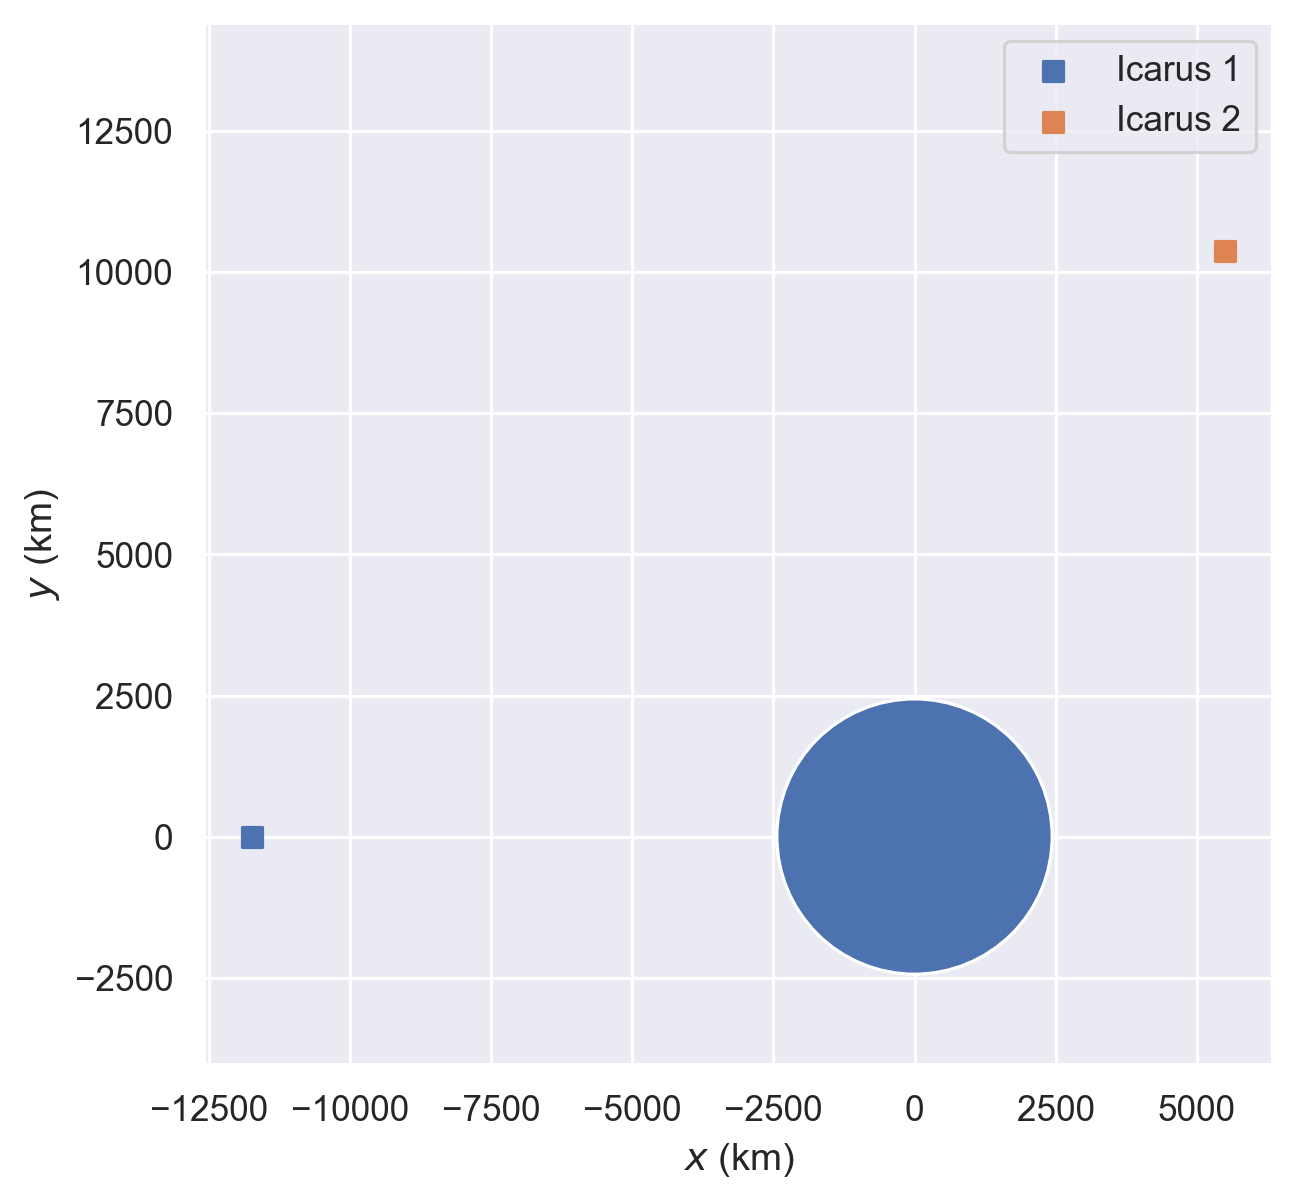

In [13]:
fig, ax = plt.subplots(dpi=230, figsize=(6, 6))

mercury = plt.Circle((0, 0), r_mercury)
ax.add_artist(mercury)

ax.scatter(pos_vec_ic1[0], pos_vec_ic1[1], label='Icarus 1', marker='s')
ax.scatter(pos_vec_ic2[0], pos_vec_ic2[1], label='Icarus 2', marker='s')

ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')

ax.axis('equal')
ax.legend()
plt.show()

### Simulation of Rendezvous

In [14]:
# https://www.thrillist.com/culture/how-much-does-manhattan-weigh
mass_manhatten = 125208467 * 907.185

# https://www.nasa.gov/feature/facts-and-figures
mass_iss = 419725

mass_ic1 = mass_manhatten + mass_iss
mass_ic2 = mass_manhatten + mass_iss

init_ic1 = [
    pos_vec_ic1[0],
    pos_vec_ic1[1],
    pos_vec_ic1[2],
    vel_vec_ic1[0],
    vel_vec_ic1[1],
    vel_vec_ic1[2],
    0,
    0,
    0,
    0,
    0,
    0
]

init_ic2_orig = [
    pos_vec_ic2[0],
    pos_vec_ic2[1],
    pos_vec_ic2[2],
    vel_vec_ic2[0],
    vel_vec_ic2[1],
    vel_vec_ic2[2],
    0,
    0,
    0,
    0,
    0,
    0
]

In [15]:
s_out_ic1, t_out_ic1 = two_body_propagator(0, 
                                           7.16*60*60, 
                                           mass_ic1, 
                                           m_mercury, 
                                           init_ic1, 
                                           grav_constant=grav_const, 
                                           tolerance=1,
                                           beta=0.7)

s_out_ic2_orig, t_out_ic2_orig = two_body_propagator(0, 
                                                     7.168*60*60, 
                                                     mass_ic2, 
                                                     m_mercury, 
                                                     init_ic2_orig, 
                                                     grav_constant=grav_const, 
                                                     tolerance=1,
                                                     beta=0.7)

ic1_x = s_out_ic1.T[0]
ic1_y = s_out_ic1.T[1]

ic2_x_orig = s_out_ic2_orig.T[0]
ic2_y_orig = s_out_ic2_orig.T[1]

len(ic1_x), len(ic2_x_orig)

(7853, 7816)

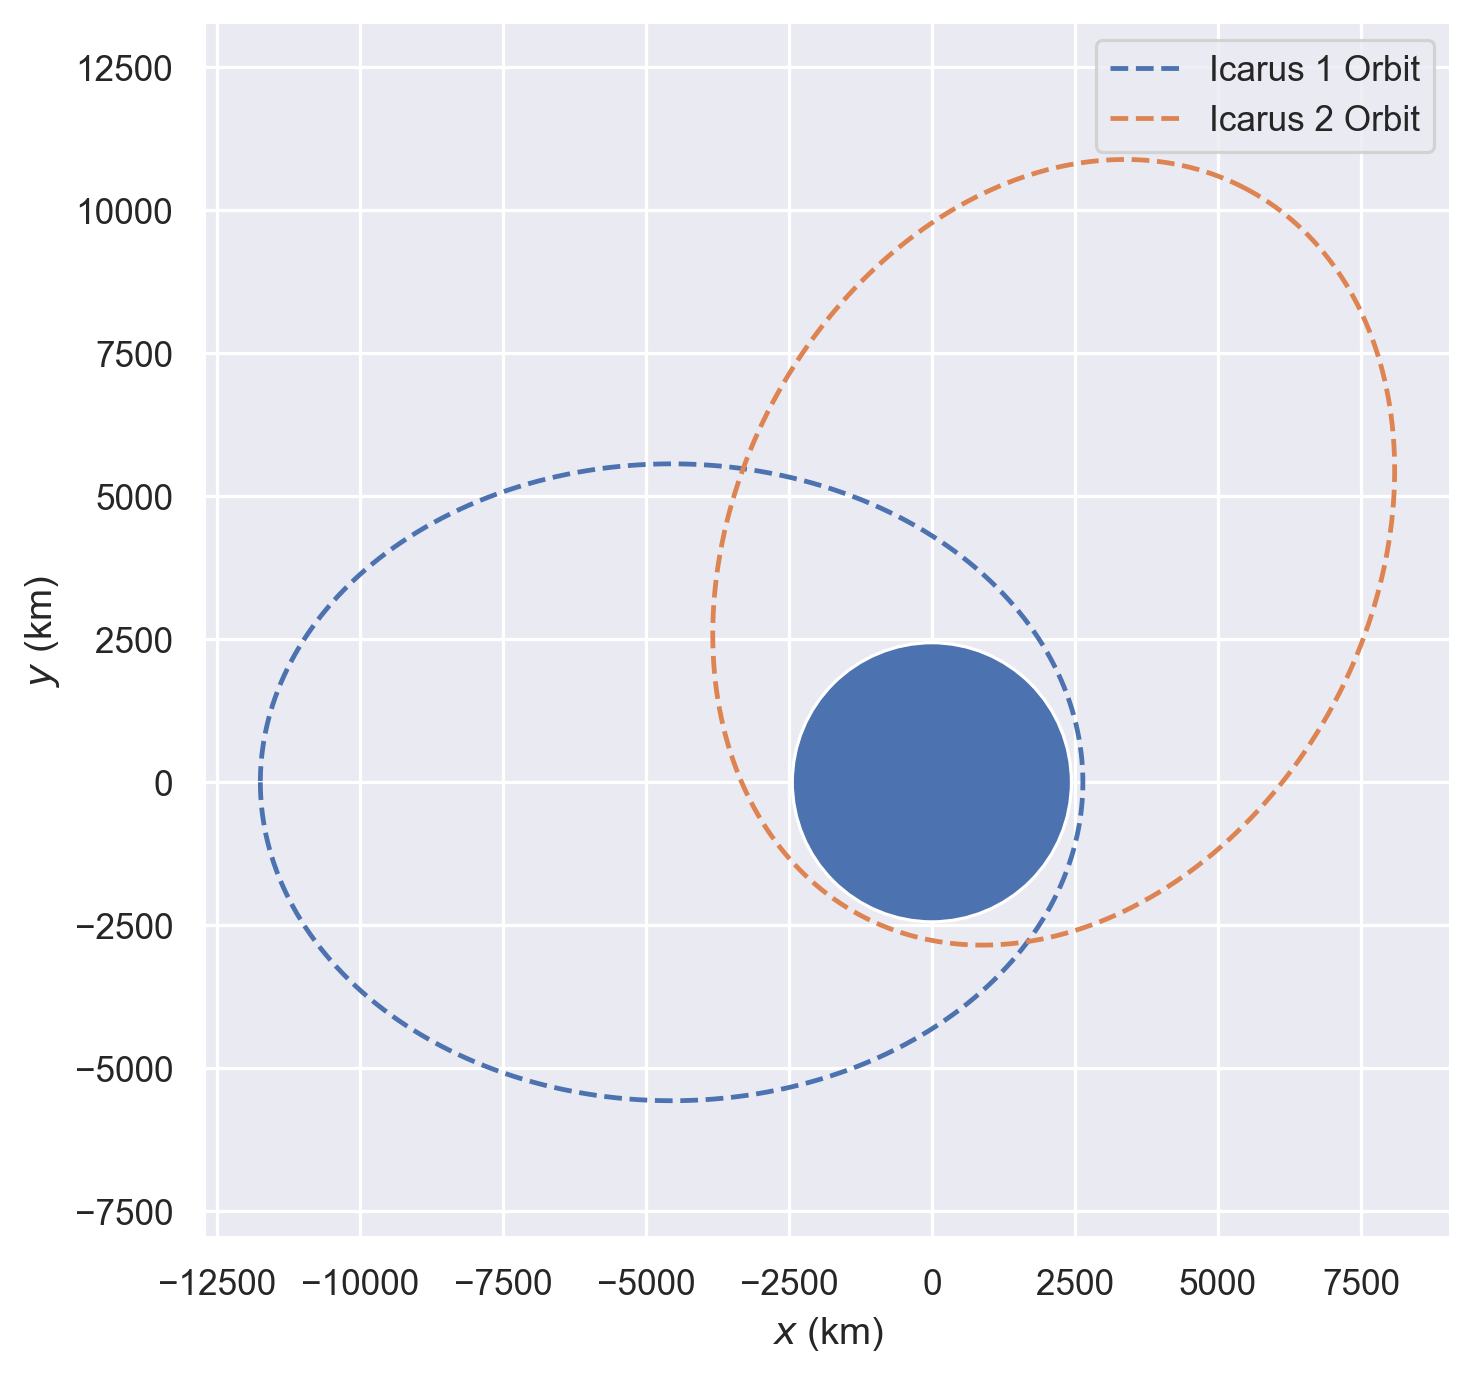

In [16]:
fig, ax = plt.subplots(dpi=230, figsize=(7, 7))

mercury = plt.Circle((0, 0), r_mercury)
ax.add_artist(mercury)

ax.plot(ic1_x, ic1_y, label='Icarus 1 Orbit', linestyle='--')
ax.plot(ic2_x_orig, ic2_y_orig, label='Icarus 2 Orbit', linestyle='--')

ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')

ax.axis('equal')
ax.legend()
plt.show()

In [17]:
v_IC2_orig = ic2_h / ra_mercury
v_IC2_circ = np.sqrt((grav_const*m_mercury) / ra_mercury)

delta_v_circ = v_IC2_circ-v_IC2_orig

v_IC2_orig, v_IC2_circ, delta_v_circ

(0.8302169819836281, 1.370105766941543, 0.5398887849579149)

In [18]:
ra_mercury, rp_mercury, ic2_h, np.sqrt(2*grav_const*m_mercury) * np.sqrt((rp_mercury*ra_mercury) / (rp_mercury+ra_mercury))

(11740, 2640, 9746.747368487795, 9746.747368487797)

In [19]:
time_transfer = ((2*np.pi / np.sqrt(grav_const*m_mercury)) * np.power(ra_mercury, 3/2)) * (ic2_asc / (2*np.pi))
time_transfer/(60*60), (2*np.pi / np.sqrt(grav_const*m_mercury)) * np.power(ra_mercury, 3/2)

(4.898240019916093, 53838.61398594901)

In [20]:
init_ic2_transfer = [
    pos_vec_ic2[0],
    pos_vec_ic2[1],
    pos_vec_ic2[2],
    v_IC2_circ * np.cos(3*np.pi/2 - ic2_asc),
    v_IC2_circ * np.sin(3*np.pi/2 - ic2_asc),
    0,
    0,
    0,
    0,
    0,
    0,
    0
]

s_out_ic2_transfer, t_out_ic2_transfer = two_body_propagator(0, 
                                                             time_transfer, 
                                                             mass_ic2, 
                                                             m_mercury, 
                                                             init_ic2_transfer, 
                                                             grav_constant=grav_const, 
                                                             tolerance=1,
                                                             beta=0.7)

ic2_x_transfer = s_out_ic2_transfer.T[0]
ic2_y_transfer = s_out_ic2_transfer.T[1]

ic2_vx_transfer = s_out_ic2_transfer.T[3]
ic2_vy_transfer = s_out_ic2_transfer.T[4]

len(ic2_x_transfer)

4769

In [21]:
ic1_x_interp = interpolate.interp1d(t_out_ic1, ic1_x)
ic1_y_interp = interpolate.interp1d(t_out_ic1, ic1_y)

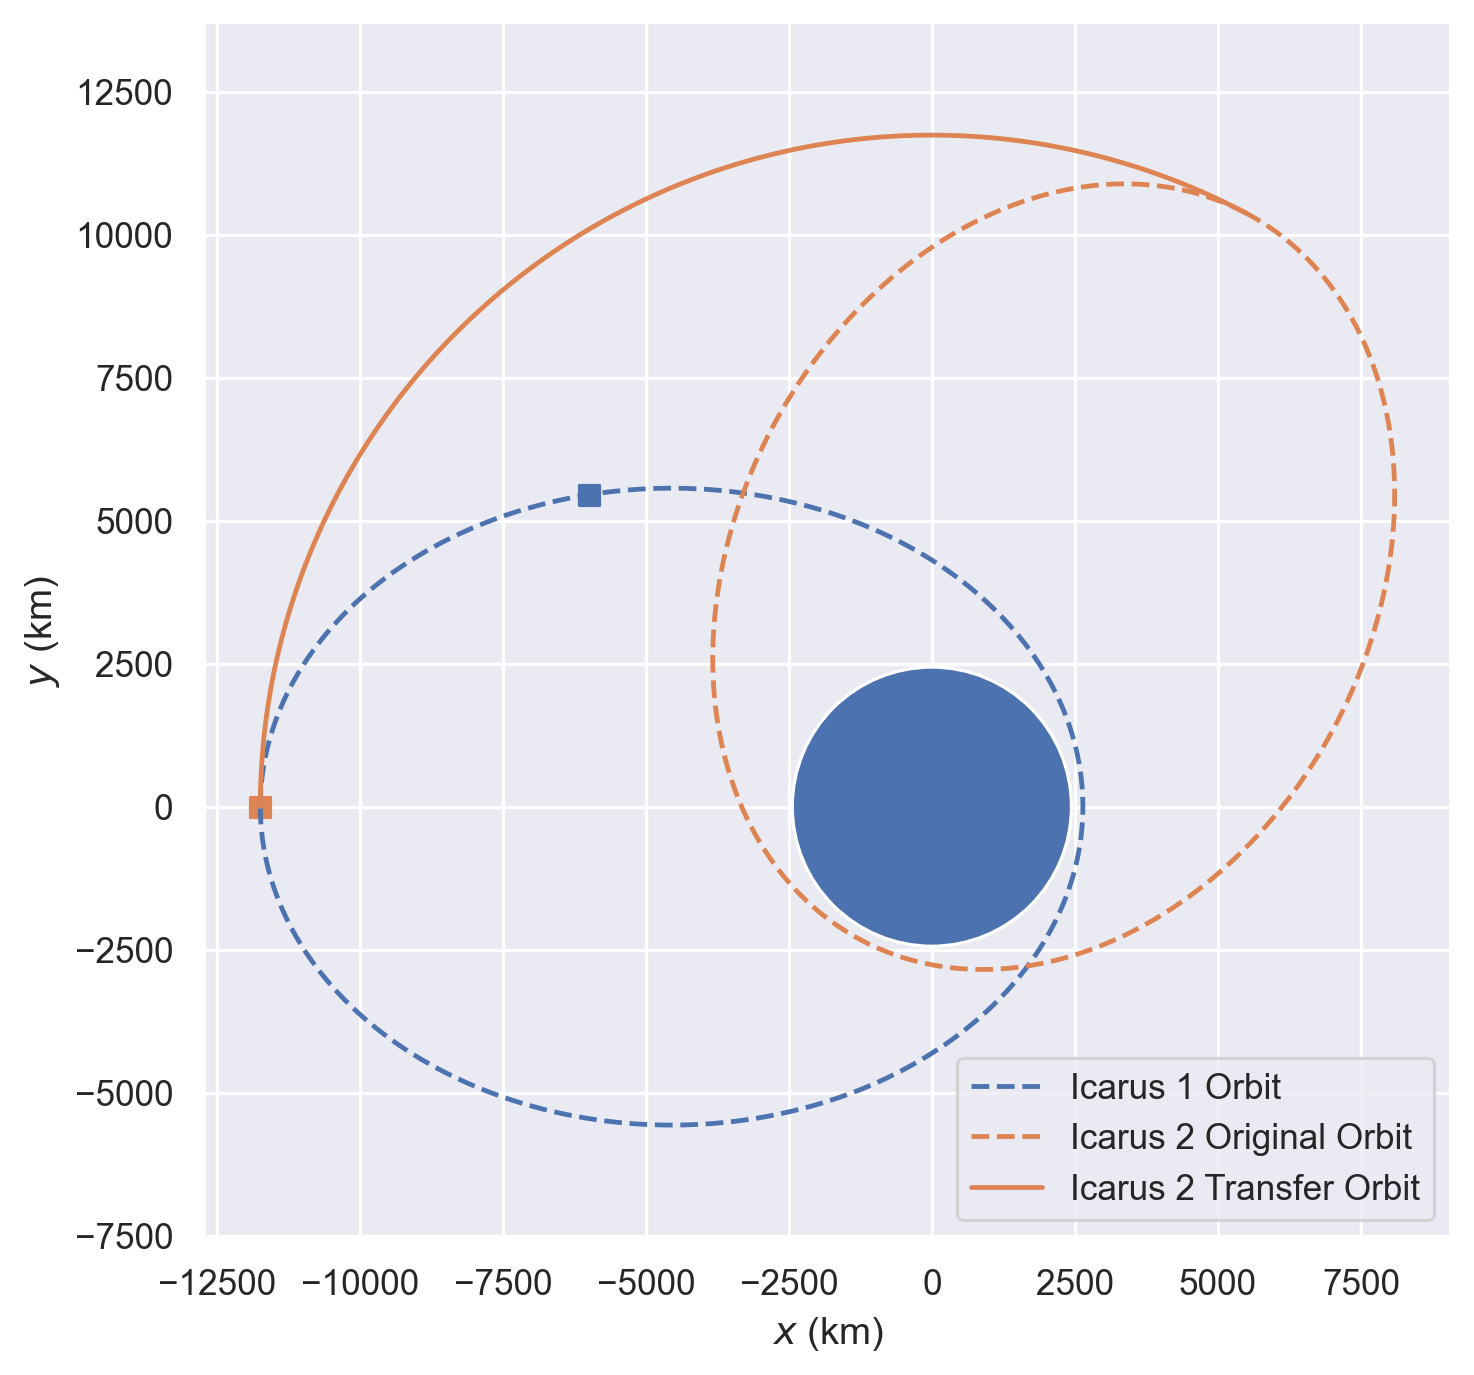

In [23]:
fig, ax = plt.subplots(dpi=230, figsize=(7, 7))

mercury = plt.Circle((0, 0), r_mercury)
ax.add_artist(mercury)

ax.plot(ic1_x, ic1_y, label='Icarus 1 Orbit', linestyle='--')

ax.plot(ic2_x_orig, ic2_y_orig, label='Icarus 2 Original Orbit', linestyle='--')
ax.plot(ic2_x_transfer, ic2_y_transfer, label='Icarus 2 Transfer Orbit', c='#dd8452')

ax.scatter(ic2_x_transfer[-1], ic2_y_transfer[-1], marker='s', c='#dd8452')
ax.scatter(ic1_x_interp(time_transfer), ic1_y_interp(time_transfer), marker='s', c='#4c72b0')

ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')

ax.axis('equal')
ax.legend()
plt.show()

In [24]:
ic2_theta_phase = np.pi
ic1_theta_phase = np.pi + np.arctan(ic1_y_interp(time_transfer) / ic1_x_interp(time_transfer))

np.degrees(ic1_theta_phase), ic1_x_interp(time_transfer), ic1_y_interp(time_transfer)

(137.66999425786173, array(-5988.29320831), array(5454.66293926))

In [25]:
ic1_elements_phase = [merc_eccentricity, 0, 0, 0, ic1_theta_phase]

pos_ic1_phase, vel_ic1_phase = geocentric_state_vector_transform(ic1_h, ic1_elements_phase, mu=grav_const*m_mercury)
pos_ic1_phase, vel_ic1_phase = pos_ic1_phase.reshape(3), vel_ic1_phase.reshape(3)

pos_ic1_phase, vel_ic1_phase

(array([-5988.29343123,  5454.66314232,     0.        ]),
 array([-1.52261301, -0.24070402,  0.        ]))

In [26]:
# find phase change
a_orig = (ra_mercury + rp_mercury)/2
period_orig = np.power(a_orig, 3/2) * 2*np.pi / np.sqrt(grav_const*m_mercury)

a_orig, period_orig, period_orig/(60*60)

(7190.0, 25803.882827697715, 7.167745229916032)

In [27]:
period_phase = period_orig + (period_orig - time_transfer)

period_phase

33974.1015836975

In [28]:
a_phase = np.power((np.sqrt(grav_const*m_mercury) * period_phase)/(2*np.pi), 2/3)
rp_phase = 2*a_phase - ra_mercury
h_phase = np.sqrt(2*grav_const*m_mercury) * np.sqrt((rp_phase*ra_mercury) / (rp_phase+ra_mercury))

va_phase = h_phase / ra_mercury

a_phase, rp_phase, h_phase, va_phase

(8637.157457317018, 5534.3149146340365, 12875.636479763203, 1.0967322384806817)

In [29]:
init_ic2_phase = [
    ic2_x_transfer[-1],
    ic2_y_transfer[-1],
    0,
    0,
    -va_phase,
    0,
    0,
    0,
    0,
    0,
    0,
    0
]

s_out_ic2_phase, t_out_ic2_phase = two_body_propagator(time_transfer, 
                                                       time_transfer+period_phase, 
                                                       mass_ic2, 
                                                       m_mercury, 
                                                       init_ic2_phase, 
                                                       grav_constant=grav_const, 
                                                       tolerance=1,
                                                       beta=0.7)

ic2_x_phase = s_out_ic2_phase.T[0]
ic2_y_phase = s_out_ic2_phase.T[1]

init_ic1_phase = [
    pos_ic1_phase[0], 
    pos_ic1_phase[1],
    0,
    vel_ic1_phase[0],
    vel_ic1_phase[1],
    0,
    0,
    0,
    0,
    0,
    0,
    0
]

s_out_ic1_phase, t_out_ic1_phase = two_body_propagator(time_transfer, 
                                                       time_transfer+period_phase, 
                                                       mass_ic1, 
                                                       m_mercury, 
                                                       init_ic1_phase, 
                                                       grav_constant=grav_const, 
                                                       tolerance=1,
                                                       beta=0.7)

ic1_x_phase = s_out_ic1_phase.T[0]
ic1_y_phase = s_out_ic1_phase.T[1]

len(ic2_x_phase), len(ic1_x_phase)

(10214, 9518)

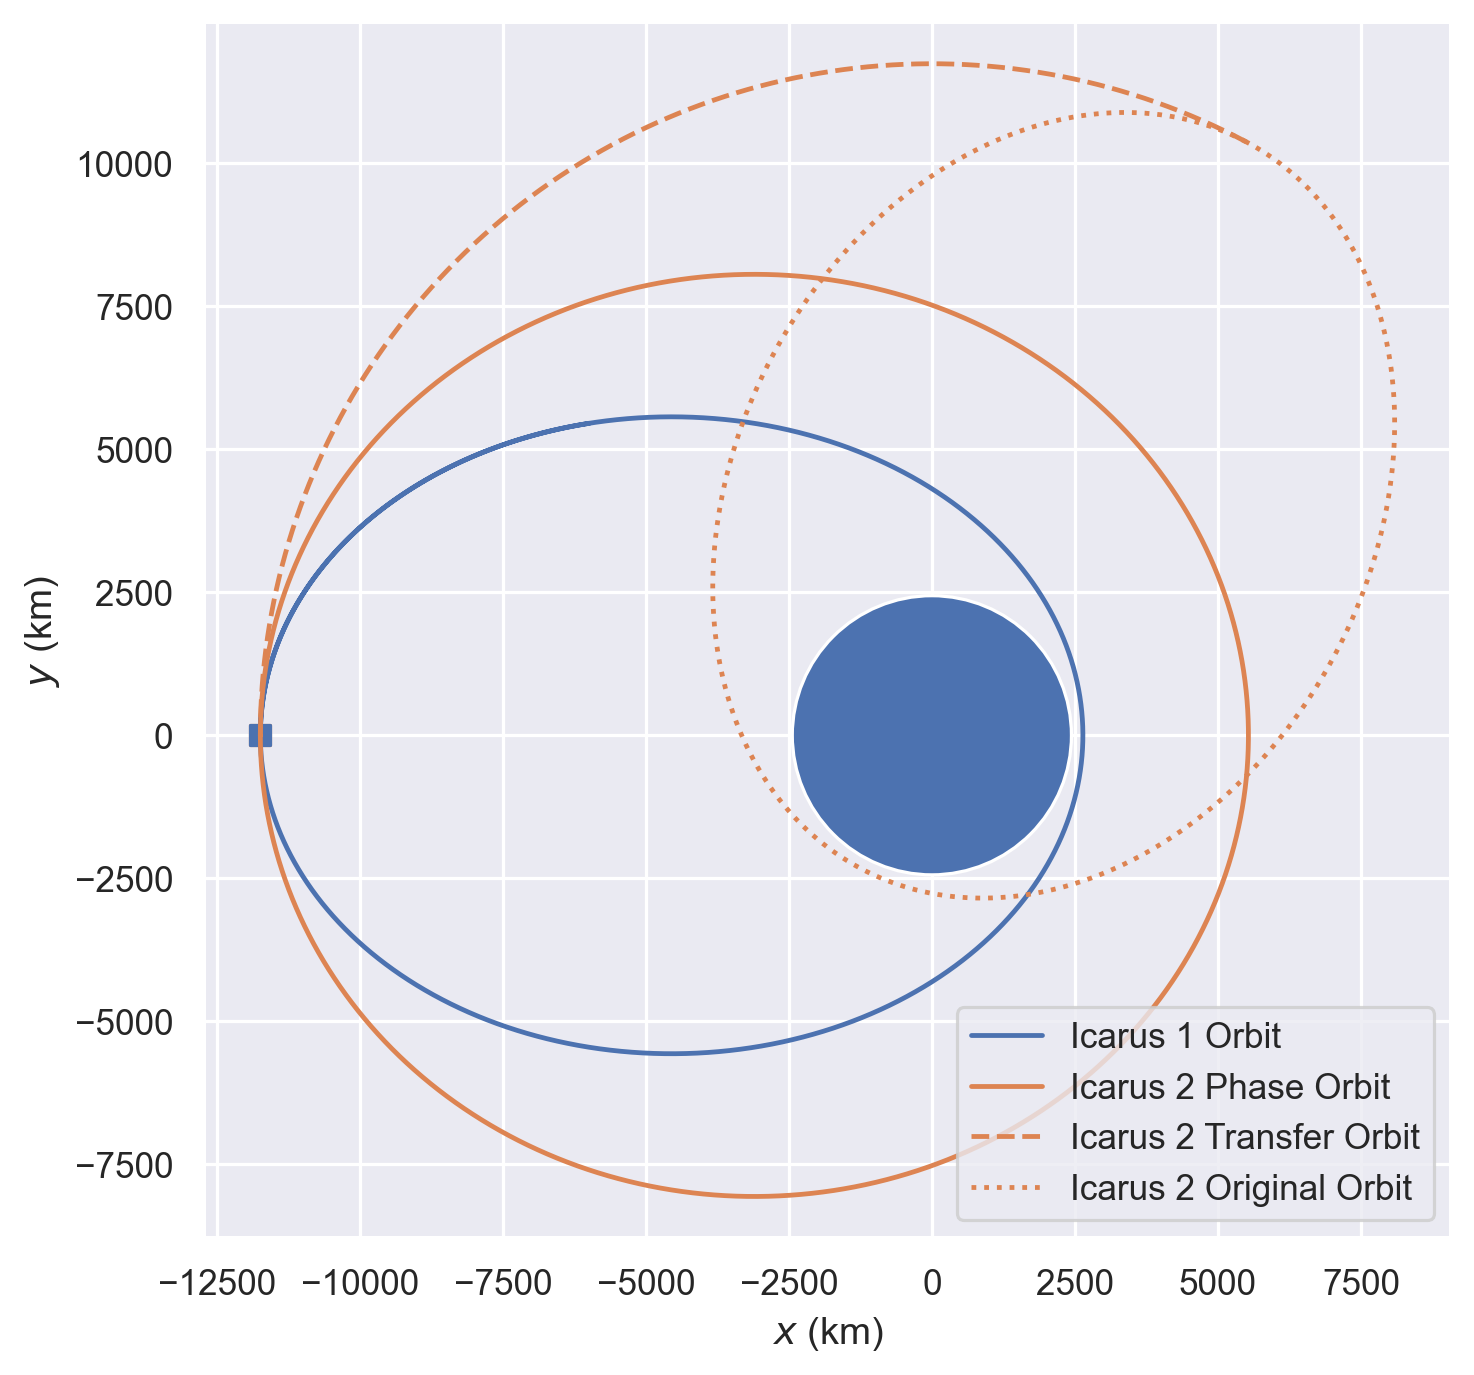

In [30]:
fig, ax = plt.subplots(dpi=230, figsize=(7, 7))

mercury = plt.Circle((0, 0), r_mercury)
ax.add_artist(mercury)

ax.plot(ic1_x_phase, ic1_y_phase, label='Icarus 1 Orbit')
ax.plot(ic2_x_phase, ic2_y_phase, label='Icarus 2 Phase Orbit', c='#dd8452')
ax.plot(ic2_x_transfer, ic2_y_transfer, label='Icarus 2 Transfer Orbit', linestyle='--', c='#dd8452')
ax.plot(ic2_x_orig, ic2_y_orig, label='Icarus 2 Original Orbit', linestyle='dotted', c='#dd8452')

ax.scatter(ic2_x_phase[-1], ic2_y_phase[-1], marker='s', c='#dd8452')
ax.scatter(ic1_x_phase[-1], ic1_y_phase[-1], marker='s', c='#4c72b0')

ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')

ax.axis('equal')
ax.legend()
plt.show()

In [31]:
np.sqrt((ic1_x_phase[-1] - ic2_x_phase[-1])**2 + (ic1_y_phase[-1] - ic2_y_phase[-1])**2)

0.6200841056152049

In [32]:
ic1_x_phase[-1], ic2_x_phase[-1], ic1_y_phase[-1], ic2_y_phase[-1]

(-11739.998197310937,
 -11739.999626466893,
 -3.9422894995607916,
 -3.322207040891091)

In [33]:
r1_delta_v = v_IC2_circ - v_IC2_orig
r2_delta_v = v_IC2_circ - va_phase
r3_delta_v = va_phase - v_IC2_orig

total_delta_v = r1_delta_v + r2_delta_v + r3_delta_v

total_time = time_transfer + period_phase

total_delta_v, total_time/(60*60)

(1.0797775699158298, 14.335490459832064)

### Animation

In [39]:
ic2_full_x = np.concatenate((ic2_x_transfer, ic2_x_phase))
ic2_full_y = np.concatenate((ic2_y_transfer, ic2_y_phase))

ic1_full_x = np.concatenate((ic1_x_interp(t_out_ic2_transfer), ic1_x_phase))
ic1_full_y = np.concatenate((ic1_y_interp(t_out_ic2_transfer), ic1_y_phase))

In [44]:
t_new = np.linspace(0, time_transfer+period_phase, 1000)

ic2_anim_x, ic2_anim_y = constant_time_transform([ic2_full_x, ic2_full_y], 
                                                 np.concatenate((t_out_ic2_transfer, t_out_ic2_phase)),
                                                 t_new)

ic1_anim_x, ic1_anim_y = constant_time_transform([ic1_full_x, ic1_full_y], 
                                                 np.concatenate((t_out_ic2_transfer, t_out_ic1_phase)),
                                                 t_new)

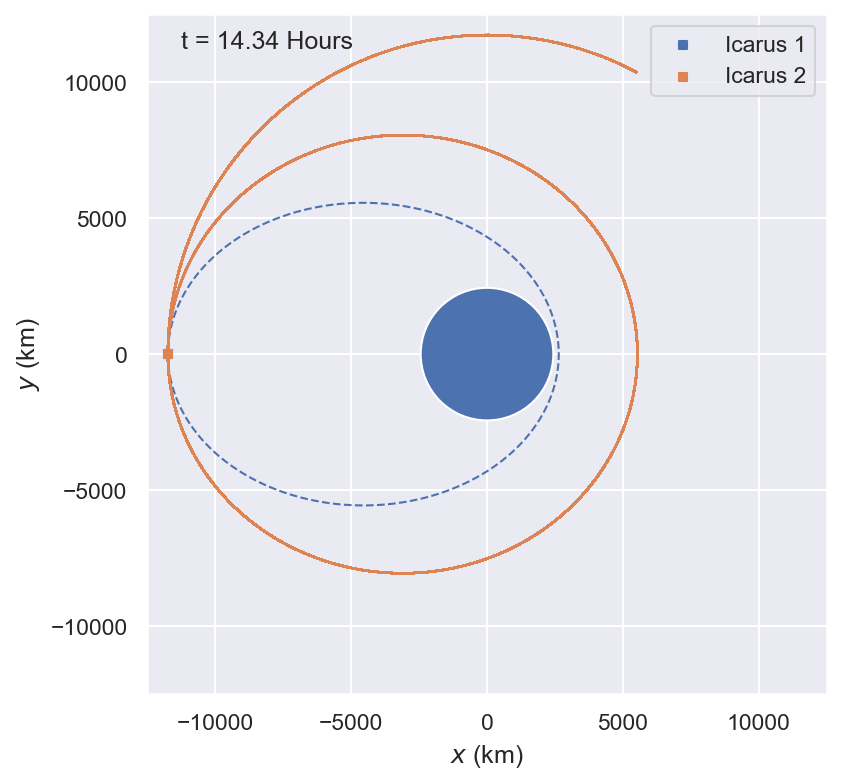

In [63]:
fig, ax = plt.subplots(figsize=(7,6), dpi=150)

time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)
ic1_point = ax.scatter(ic1_anim_x[0], ic1_anim_y[0], s=13, marker='s', c='#4c72b0', label='Icarus 1')
ic2_point = ax.scatter(ic2_anim_x[0], ic2_anim_y[0], s=13, marker='s', c='#dd8452', label='Icarus 2')

def animate(i):
    ax.plot(ic2_anim_x[0:i], ic2_anim_y[0:i], linewidth=1, c='#dd8452')
    
    ic1_point.set_offsets([ic1_anim_x[i], ic1_anim_y[i]])
    ic2_point.set_offsets([ic2_anim_x[i], ic2_anim_y[i]])
    
    time_text.set_text(f't = {round(t_new[i]/(60 * 60), 2)} Hours')

    
ax.plot(ic1_x, ic1_y, linestyle='--', linewidth=1, c='#4c72b0')

mercury = plt.Circle((0, 0), r_mercury)
ax.add_artist(mercury)

ax.set_xlim(-12500, 12500)
ax.set_ylim(-12500, 12500)

ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')

plt.gca().set_aspect('equal')

ax.legend()

ani = animation.FuncAnimation(fig, animate, frames=1000)
ani.save('rendezvous.gif', writer='pillow', fps=30)

## Question 3

In [34]:
press_init = 1.01325e5
press_final = 1.322e-11
v_airlock = 8
a_airlock = 4

time_depressurization = 0.005*(v_airlock/a_airlock)*np.log(press_init / press_final)
time_depressurization

0.3657537873300151

In [35]:
time = np.linspace(0, time_depressurization, num=250)
press_vec = press_init / np.exp(200 * time * (a_airlock / v_airlock))

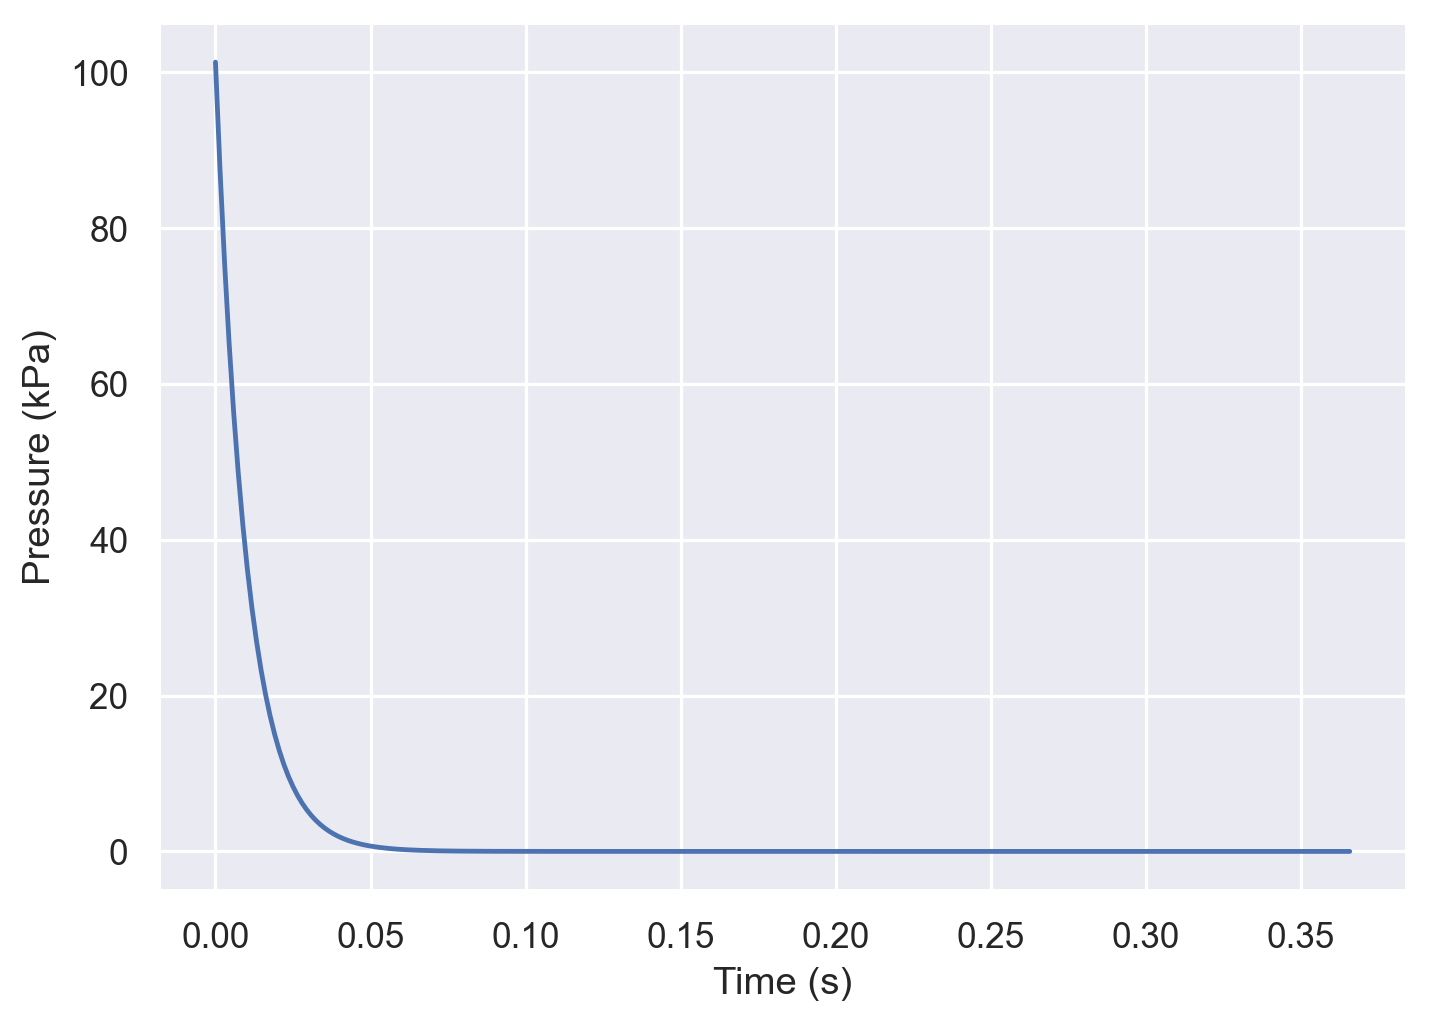

In [36]:
plt.figure(dpi=230, figsize=(7,5))

plt.plot(time, press_vec/1e3)

plt.xlabel('Time (s)')
plt.ylabel('Pressure (kPa)')

plt.show()

In [37]:
 ((343.2 / 2)**2 * 4)/ (287.05 * 293.15)

1.3997391463202211

In [38]:
force_body = ((343.2 / 2)**2 * a_airlock) * press_vec / (287.05 * 293.15)

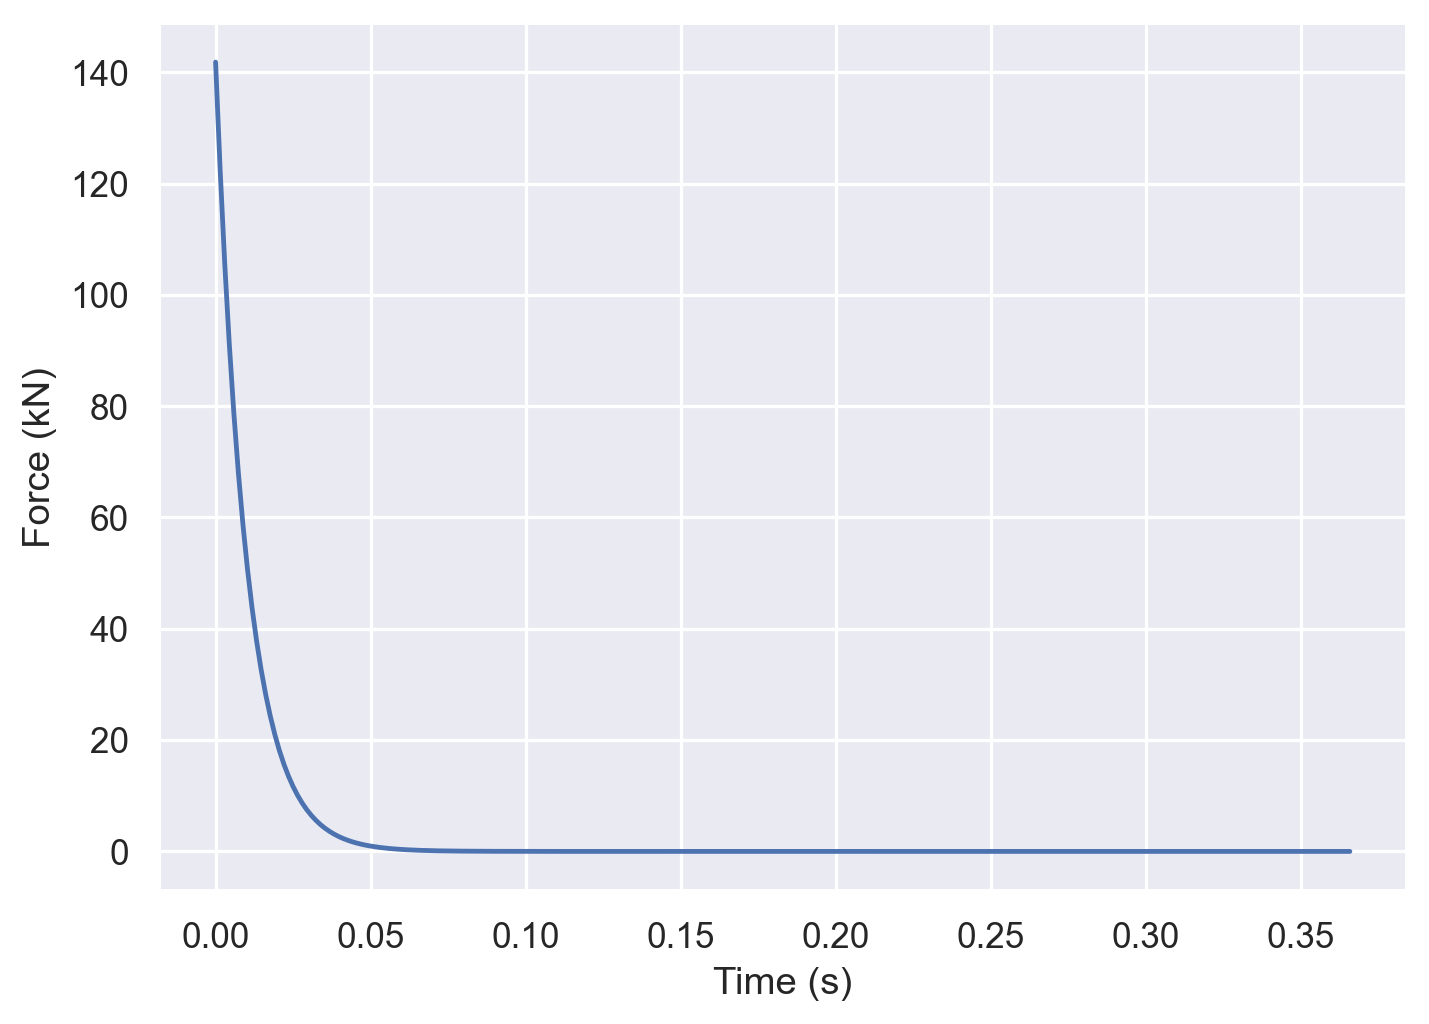

In [39]:
plt.figure(dpi=230, figsize=(7,5))

plt.plot(time, force_body/1e3)

plt.xlabel('Time (s)')
plt.ylabel('Force (kN)')

plt.show()

In [40]:
accel = force_body / 697.31
vel = [0]

vel = accel[1:] * np.diff(time)
vel = np.insert(vel, 0, 0, axis=0)

vel_vec = [sum(vel[:i]) for i in range(len(vel))]

pos = vel_vec[1:] * np.diff(time)
pos = np.insert(pos, 0, 0, axis=0)

pos_vec = [sum(pos[:i]) for i in range(len(pos))]

In [41]:
vel_vec[-1], pos_vec[-1]

(1.888212652095193, 0.6675444967373526)

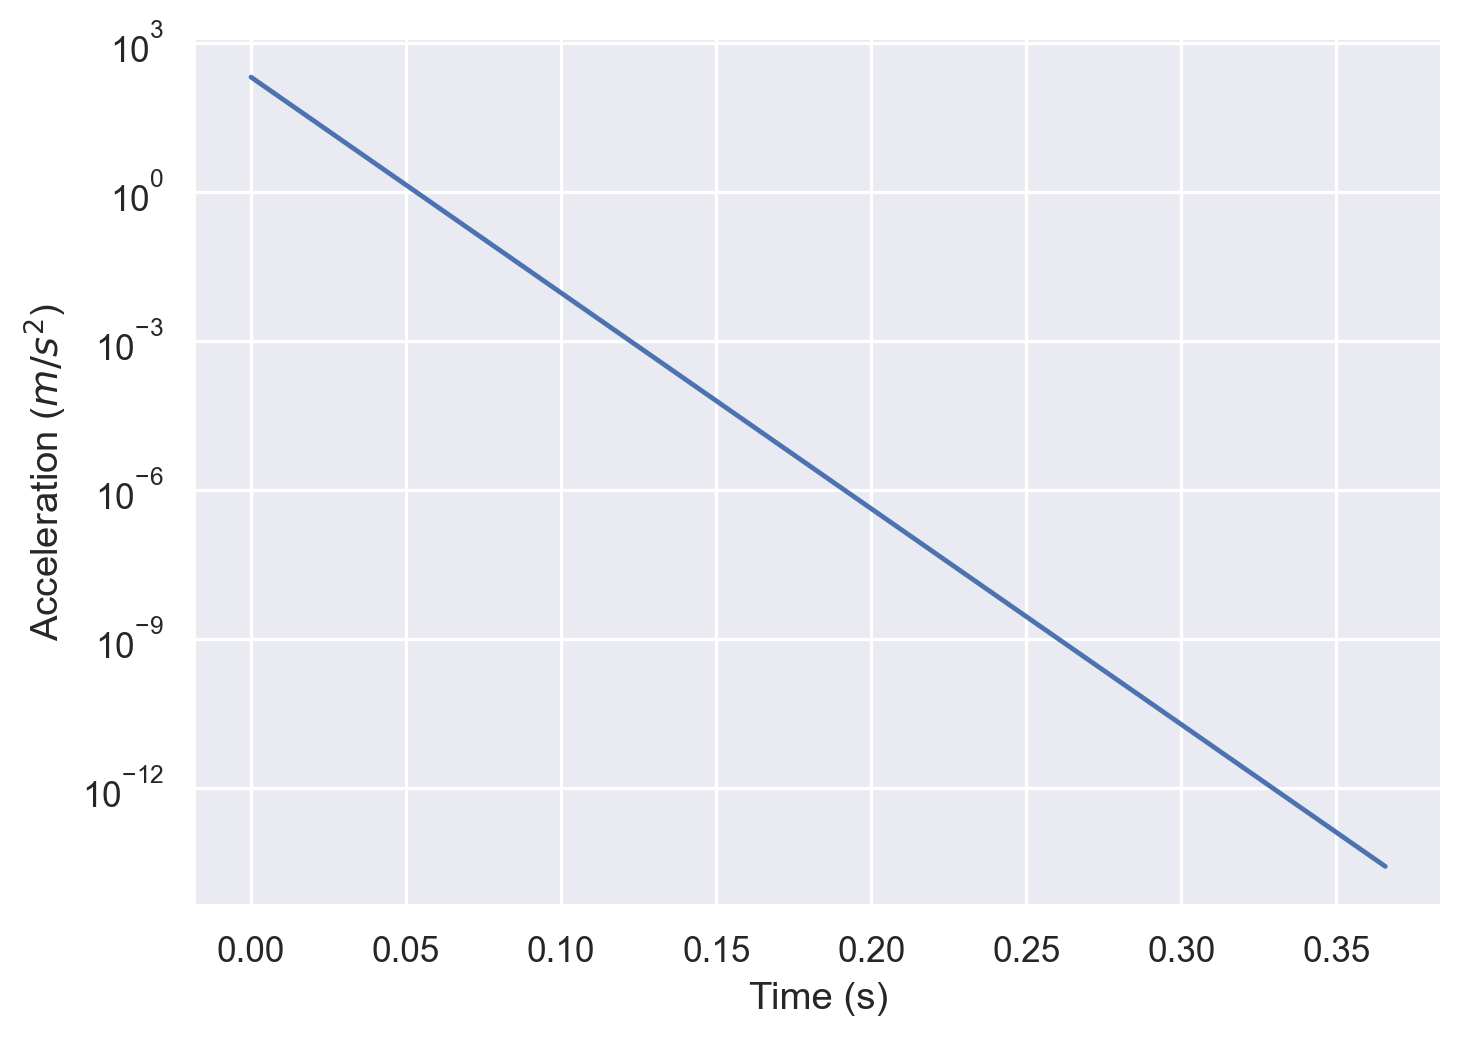

In [42]:
plt.figure(dpi=230, figsize=(7,5))

plt.semilogy(time, accel)

plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration ($m/s^2$)')
plt.grid(True, which='minor', ls="-")

plt.show()

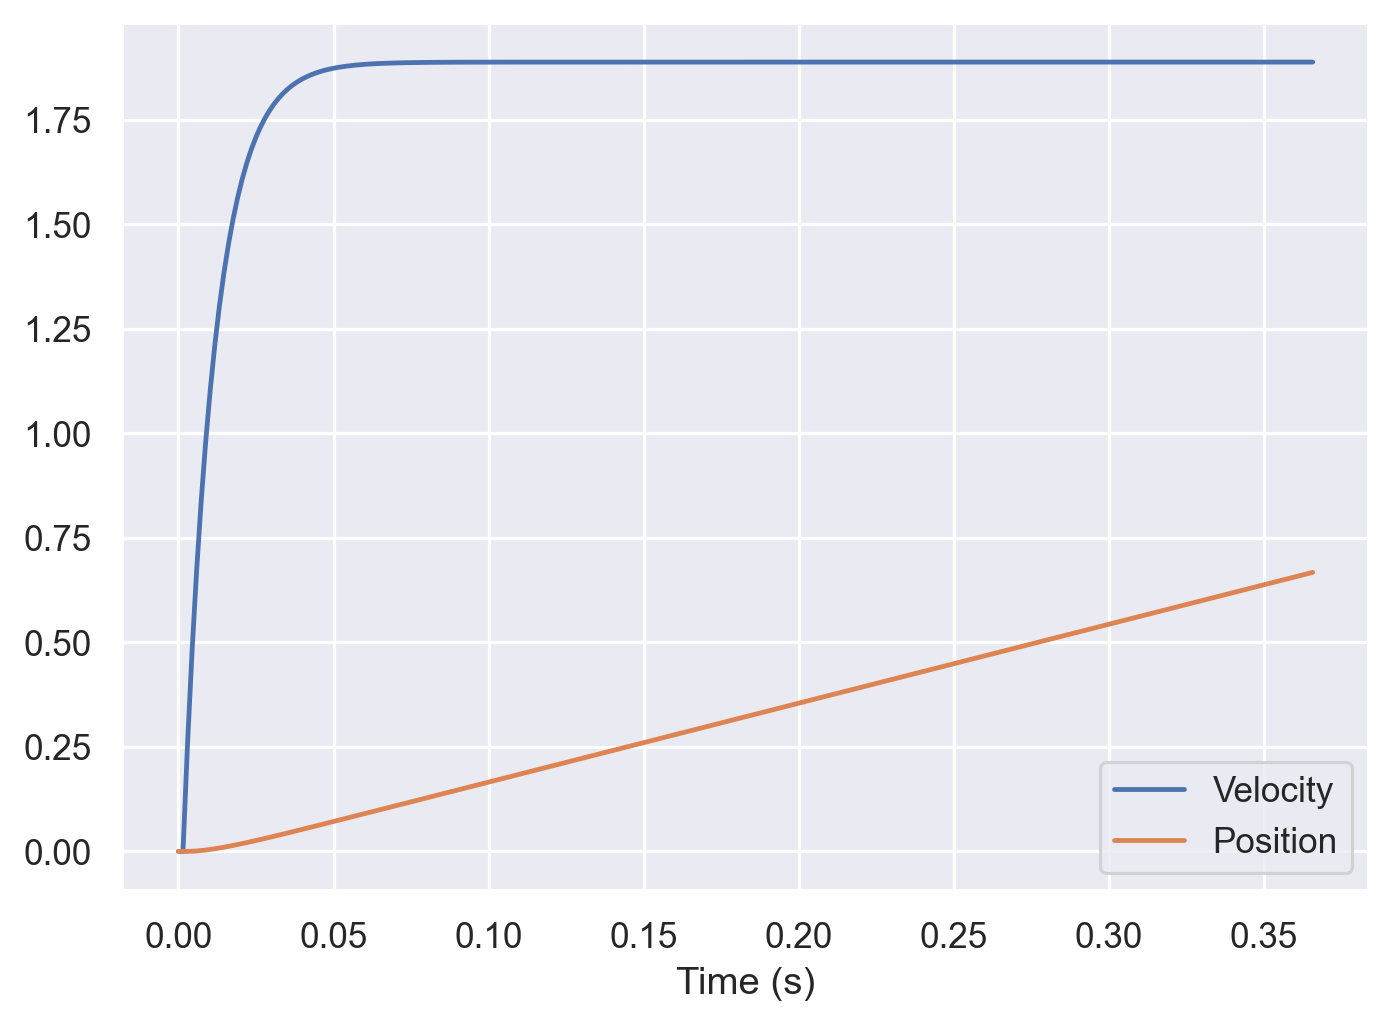

In [43]:
plt.figure(dpi=230, figsize=(7,5))

plt.plot(time, vel_vec, label='Velocity')
plt.plot(time, pos_vec, label='Position')

plt.xlabel('Time (s)')

plt.legend()
plt.show()

In [44]:
# find time required to reach 20 m
final_vel = vel_vec[-1]
final_pos = pos_vec[-1]

time_gap = (20 - final_pos)/final_vel
time_total = time_gap + time_depressurization

time_total

10.604248631547389

In [45]:
r_IC1 = 9300
r_IC2 = np.sqrt(0.020**2 + r_IC1**2)

r_IC2

9300.000000021506

In [46]:
#grav_const = 6.6742e-20
#m_mercury = 330.2e21

v_IC1 = np.sqrt((grav_const * m_mercury) / r_IC1)
v_IC2 = np.sqrt((grav_const * m_mercury) / r_IC2)

v_IC1, v_IC2

(1.5393829373995898, 1.5393829373978098)

In [47]:
v_IC2 * (r_IC1 / r_IC2)

1.53938293739425

In [48]:
v_IC2 * (0.020 / r_IC2)

3.3105009406327962e-06

### Simulation of Jump

In [49]:
r_12_sm = 58e6
rg = (r_12_sm * m_mercury) / (m_mercury + m_sun)
merc_g_dist = r_12_sm - rg

sim_time = 10.60

rg, merc_g_dist, -merc_g_dist + r_IC1

(9.628756571435183, 57999990.37124343, -57990690.37124343)

In [50]:
# icarus 1 simulation
sim1_conditions = [-merc_g_dist + r_IC1, 0, 0, 0, v_IC1, 0]

sim1_s, sim1_t = three_body_cr_propagator(0, 
                                          sim_time,
                                          m_mercury,
                                          m_sun,
                                          r_12_sm,
                                          sim1_conditions,
                                          grav_constant=grav_const, 
                                          tolerance=0.003)

ic1_x = sim1_s.T[0]
ic1_y = sim1_s.T[1]

ic1_vx = sim1_s.T[3]
ic1_vy = sim1_s.T[4]

len(ic1_x)

599

In [51]:
# icarus 2 simulation
sim2_conditions = [-merc_g_dist + r_IC1, 0.020, 0, v_IC2 * (0.020 / r_IC2), v_IC2 * (r_IC1 / r_IC2), 0]

sim2_s, sim2_t = three_body_cr_propagator(0, 
                                          sim_time,
                                          m_mercury,
                                          m_sun,
                                          r_12_sm,
                                          sim2_conditions,
                                          grav_constant=grav_const, 
                                          tolerance=0.003)

ic2_x = sim2_s.T[0]
ic2_y = sim2_s.T[1]

ic2_vx = sim2_s.T[3]
ic2_vy = sim2_s.T[4]

len(ic2_x)

599

In [52]:
force_func = interpolate.interp1d(time, force_body)

def body_thrust(t, x, y, z, v_x, v_y, v_z, m, omega, r_1, r_2, r_12, mu_1, mu_2, pi_1, pi_2):
    if time[0] <= t <= time[-1]:
        return 0, force_func(t)/m, 0
    else:
        return 0, 0, 0

In [53]:
time[0], time[-1]

(0.0, 0.3657537873300151)

In [54]:
# body simulation

sim3_s, sim3_t = three_body_cr_thrust_propagator(0, 
                                                 sim_time,
                                                 sim1_conditions,
                                                 body_thrust,
                                                 697.31,
                                                 m_mercury,
                                                 m_sun,
                                                 r_12_sm,
                                                 grav_constant=grav_const, 
                                                 tolerance=0.0005)

body_x = sim3_s.T[0]
body_y = sim3_s.T[1]

body_vx = sim3_s.T[3]
body_vy = sim3_s.T[4]

len(body_x)

3624

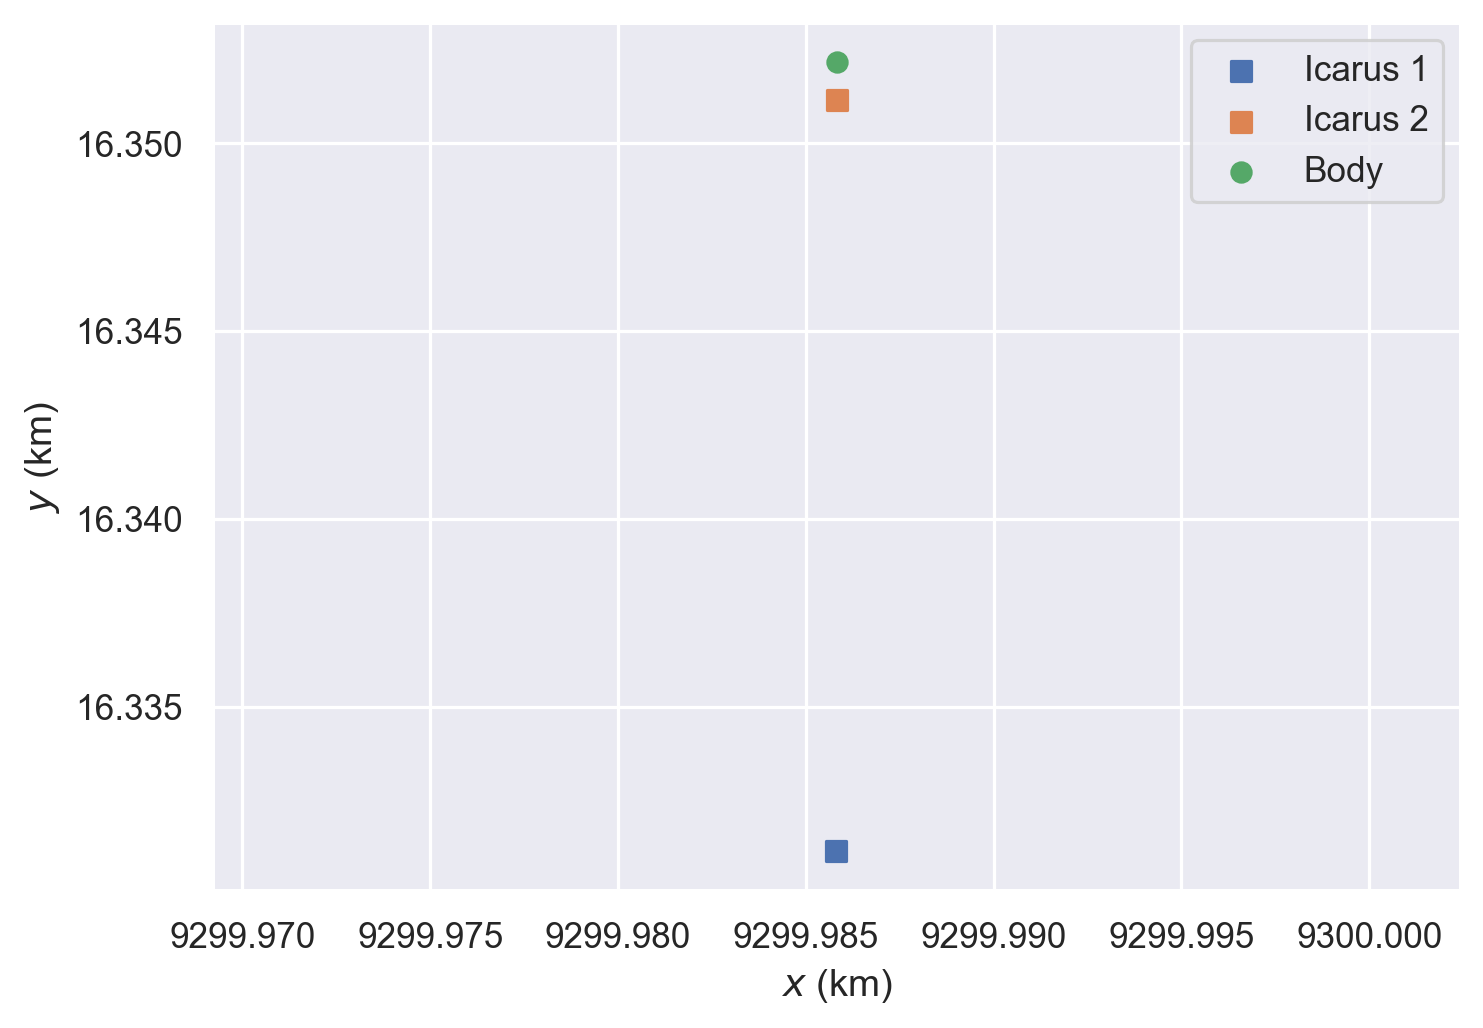

In [55]:
fig, ax = plt.subplots(dpi=230, figsize=(7, 5))

mercury = plt.Circle((0, 0), r_mercury)
ax.add_artist(mercury)

ax.scatter(ic1_x[-1] + merc_g_dist, ic1_y[-1], label='Icarus 1', marker='s')
ax.scatter(ic2_x[-1] + merc_g_dist, ic2_y[-1], label='Icarus 2', marker='s')
ax.scatter(body_x[-1] + merc_g_dist, body_y[-1], label='Body')

ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')

ax.ticklabel_format(useOffset=False, style='plain')

ax.axis('equal')
ax.legend()
plt.show()

In [56]:
table = {
    'Value': ['Time (s)', 'x (km)', 'y (km)'],
    'Icarus 1': [sim1_t[-1], ic1_x[-1] + merc_g_dist, ic1_y[-1]],
    'Icarus 2': [sim2_t[-1], ic2_x[-1] + merc_g_dist, ic2_y[-1]],
    'Body': [sim3_t[-1], body_x[-1] + merc_g_dist, body_y[-1]]
}

pd.DataFrame(data=table)

,Value,Icarus 1,Icarus 2,Body
0,Time (s),10.608895,10.608895,10.602447
1,x (km),9299.985805,9299.985840,9299.985822
2,y (km),16.331143,16.351143,16.352158


In [57]:
center_pos = 9299.985840e3
body_pos = 9299.985822e3

In [58]:
center_pos-1, center_pos+1, body_pos

(9299984.84, 9299986.84, 9299985.822)

In [59]:
center_pos-1 <= body_pos <= center_pos+1

True